In [1]:
from os import walk
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
import seaborn as sns
import numpy as np
#sns.set()

#path to your input result folder
result_path = "../hardware/results"
#path to the output csv
csv_path= "./results.csv"


def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter


In [14]:
print("Processing files at", result_path)

todo, done = 0, 0
for (dirpath, dirnames, filenames) in walk(result_path):
    for filename in filenames:
        if filename == "transcript":
            todo+=1

configs = []
tot_df = pd.DataFrame()
for (dirpath, dirnames, filenames) in walk(result_path):
    num_cores = -1
    num_data = -1
    num_local_data = -1
    max_val = -1
    seed = -1
            
    for filename in filenames:
        if filename != "transcript":
            continue
        p = re.compile("[0-9]+")
        # Get parameters from the directory name first
        num_cores, num_data, max_val, seed = dirpath.split('/')[-2].split('_')[-4:]
        num_cores, num_data, max_val, seed = int(num_cores), int(num_data), int(max_val), int(seed)
        nul_local_data = int(num_data / num_cores)
        # Override them based on transcript if any
        with open(dirpath+"/"+filename, "r") as fp:
            for line in fp.readlines():
                if "Benchmark" not in line:
                    continue
                p = re.compile("[0-9]+")
                print([a.group() for a in p.finditer(line)])
                num_cores, num_data, num_local_data = [a.group() for a in p.finditer(line)]
                num_cores, num_data, num_local_data = int(num_cores), int(num_data), int(num_local_data)
                if "ERROR" in line:
                    print("ERROR")
                    assert(0)

        # Read CSV
        print("\r{}/{}".format(done, todo), end="")
        done += 1
        df = pd.read_csv(dirpath+"/results.csv", index_col=0)
        df["num_cores"] = int(num_cores)
        df["num_data"] = int(num_data)
        df["num_local_data"] = int(num_local_data)
        df["max_val"] = int(max_val)
        df["seed"] = int(seed)
        # Concat everyone
        configs.append([num_cores, num_data, num_local_data])
        tot_df = pd.concat([tot_df, df], axis=0, join="outer", ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)
print("")
# Drop nans
to_drop = tot_df.columns[tot_df.isnull().any()]
for nan_col in to_drop:
    assert(not nan_col in ['cycles', 'num_data', 'num_cores'])
    tot_df = tot_df.drop(nan_col, axis=1)

# Drop strings
tot_df = tot_df.select_dtypes(exclude=['object'])

tot_df.to_csv(csv_path)
print("Results exported to", csv_path)

Processing files at ../hardware/results
251/252
Results exported to ./results.csv


In [11]:
tot_df = pd.read_csv(csv_path)
print(tot_df.shape)
print(tot_df.head())

(50772, 16)
   core  section  start    end  cycles  snitch_loads  snitch_stores  \
0     0        0  18928  22228    3301           512            512   
1     0        1  22230  28305    6076           590            102   
2     0        2  28307  28307       1             0              0   
3     1        0  19828  31312   11485           279            283   
4     1        1  31314  33755    2442           315             49   

   snitch_avg_load_latency  snitch_occupancy  total_ipc  snitch_issues  \
0                10.253906          0.428658   0.428658           1415   
1                 4.149153          0.528802   0.528802           3213   
2                 0.000000          1.000000   1.000000              1   
3                 9.581227          0.125990   0.125990           1447   
4                 1.412698          0.700246   0.700246           1710   

   num_cores  num_data  num_local_data  max_val        seed  
0          1         2              -1       32  16713

In [4]:
# iddx of the CI of the median with 95%
def ci_idx(n):
    return [int((n-1.96*np.sqrt(n))/2), int(np.ceil(1+(n+1.96*np.sqrt(n))/2))]

# return (ci_low, median, ci_high) for a list of values
def median_and_ci(data):
    n = len(data)
    a, b = ci_idx(n)
    data_sorted = sorted(data)
    return data_sorted[a], data_sorted[int(n/2)], data_sorted[min(b, n-1)]

def get_median(data):
    return median_and_ci(data)[1]
def get_ci(data):
    a, b, c = median_and_ci(data)
    return a, c

def get_ideal_speedup(a, b, n=100):
    X = np.linspace(a, b, num=n)
    return X, X

Tot_df : (50772, 15)
Experiment : (10824, 15)
( 1 , 8 ) : ( 0.486473 , 0.487314 , 0.498653 )
( 2 , 8 ) : ( 0.244408 , 0.245096 , 0.251477 )
( 4 , 8 ) : ( 0.123898 , 0.12454 , 0.128183 )
( 8 , 8 ) : ( 0.063223 , 0.064258 , 0.066339 )
( 16 , 8 ) : ( 0.033176 , 0.033845 , 0.034797 )
( 32 , 7 ) : ( 0.018516 , 0.019038 , 0.019474 )
( 64 , 7 ) : ( 0.011013 , 0.011441 , 0.012491 )
( 128 , 7 ) : ( 0.007148 , 0.007766 , 0.009228 )
( 256 , 7 ) : ( 0.004985 , 0.005271 , 0.006194 )


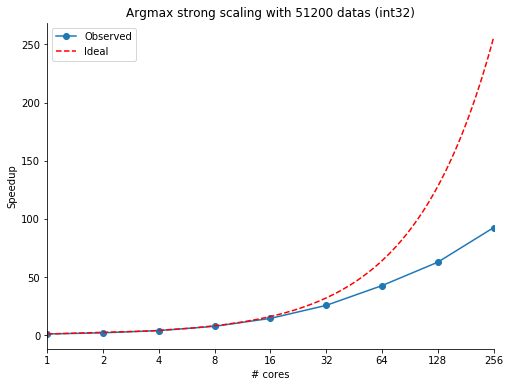

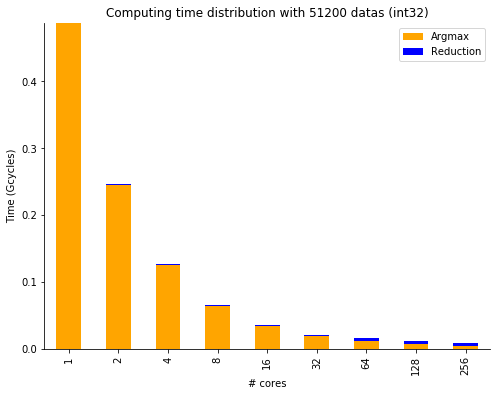

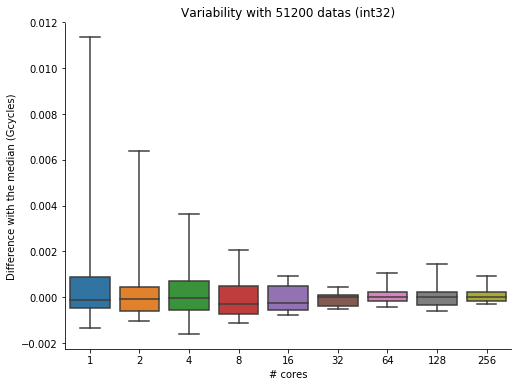

In [15]:
print("Tot_df :", tot_df.shape)

colors = [(200, "green")]


#
# Strong scaling with confidence intervals
#

for num_data, color in colors: #tot_df['num_data'].unique():
    experiment_df = tot_df.loc[tot_df['num_data'] == num_data]
    print("Experiment :", experiment_df.shape)
    Y1, Y1_low, Y1_high = [], [], []
    Y1_fill, Y1_argmax, Y1_reduction = [], [], []
    num_cores_arr = [1, 2, 4, 8, 16, 32, 64, 128, 256]
    all_cores = []
    all_tot = []
    for num_cores in num_cores_arr:
        res_fill = []
        res_argmax = []
        res_reduction = []
        res_tot = []
        maxs = []
        for seed in experiment_df['seed'].unique():
            mask = (experiment_df['seed'] == seed) & (experiment_df['num_cores'] == num_cores)
            masked = experiment_df[mask]
            if masked.empty:
                continue
            res_fill.append(      masked.loc[masked['section'] == 0]['cycles'].max() / 1000000 )
            res_argmax.append(    masked.loc[masked['section'] == 1]['cycles'].max() / 1000000 )
            res_reduction.append( masked.loc[masked['section'] == 2]['cycles'].max() / 1000000 )
            # All does not count fill section
            res_tot.append(       masked[masked['section']!=0].groupby(['core']).cycles.sum().max() / 1000000)
            all_cores.append(     num_cores)
            all_tot.append(       masked[masked['section']!=0].groupby(['core']).cycles.sum().max() / 1000000)
        if len(res_tot) == 0:
            continue
        lo, median, hi = median_and_ci(res_tot)
        Y1.append(median)
        Y1_low.append(lo)
        Y1_high.append(hi)
        Y1_fill.append(get_median(res_fill))
        Y1_argmax.append(get_median(res_argmax))
        Y1_reduction.append(get_median(res_reduction))
        print("(", num_cores, ",", len(res_tot), ")", end=" : ")
        print("(", lo, ",", median, ",", hi, ")")
    
    Y1 = np.array(Y1)
    all_cores = np.array(all_cores)
    all_tot = np.array(all_tot)
    
    #plot_errorbars()
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xscale('log', basex=2)
    ax.set_xlim(1, 256)
    ax.set_xticks(num_cores_arr)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #sns.pointplot(num_cores_arr, Y1[0]/Y1, errorbar=get_ci, join=False, ax=ax)
    #sns.pointplot(num_cores_arr, 2*Y1[0]/Y1, errorbar=get_ci, join=False, ax=ax)
    plt.plot(num_cores_arr, Y1[0]/Y1, '-o', label="Observed")
    plt.plot(get_ideal_speedup(1, 256)[0], get_ideal_speedup(1, 256)[1], '--', color="red", label="Ideal")
    plt.legend()
    plt.title("Argmax strong scaling with " + str(num_data * 256) + " datas (int32)")
    plt.xlabel("# cores")
    plt.ylabel("Speedup")
    
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plot_df = pd.DataFrame({'Cores': num_cores_arr, 'Fill': Y1_fill, 'Argmax': Y1_argmax, 'Reduction': Y1_reduction}, \
                           columns = ['Cores', 'Fill', 'Argmax', 'Reduction'])
    plot_df = plot_df.set_index('Cores')
    plot_df.drop(columns=['Fill']).plot(kind='bar', stacked=True, color=['orange', 'blue'], ax=ax)
    plt.title("Computing time distribution with " + str(num_data * 256) + " datas (int32)")
    plt.xlabel("# cores")
    plt.ylabel("Time (Gcycles)")
    
    fig = plt.figure(figsize=(8, 6), dpi=80)
    filter_box = all_cores == 1
    
    # Remove median
    for num_cores in num_cores_arr:
        idx = np.where(all_cores == num_cores)
        median = get_median(all_tot[idx])
        all_tot[idx] -= median

    ax = fig.add_subplot(1, 1, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plot_df = pd.DataFrame({'Cores': all_cores,
                            'Total': all_tot}, \
                           columns = ['Cores', 'Total'])
    sns.boxplot(data=plot_df, x="Cores", y="Total", whis=10, ax=ax)
    plt.title("Variability with " + str(num_data * 256) + " datas (int32)")
    plt.xlabel("# cores")
    plt.ylabel("Difference with the median (Gcycles)")
    

Tot_df : (50772, 15)
Num cores: 1 Experiment : (132, 15)
( 2 , 8 ) : ( 0.005208 , 0.005573 , 0.006077 )
( 4 , 4 ) : ( 0.010516 , 0.010843 , 0.010845 )
( 8 , 4 ) : ( 0.020029 , 0.02066 , 0.020662 )
( 16 , 4 ) : ( 0.039611 , 0.040147 , 0.040787 )
( 32 , 4 ) : ( 0.078722 , 0.081922 , 0.09276 )
( 64 , 8 ) : ( 0.156508 , 0.157147 , 0.158513 )
( 128 , 4 ) : ( 0.312434 , 0.314297 , 0.315818 )
( 200 , 8 ) : ( 0.486473 , 0.487314 , 0.498653 )
Num cores: 256 Experiment : (33024, 15)
( 2 , 8 ) : ( 0.001396 , 0.001477 , 0.001515 )
( 4 , 4 ) : ( 0.001741 , 0.001813 , 0.001896 )
( 8 , 4 ) : ( 0.002411 , 0.002558 , 0.002601 )
( 16 , 4 ) : ( 0.002705 , 0.002832 , 0.00286 )
( 32 , 4 ) : ( 0.003063 , 0.003312 , 0.004926 )
( 64 , 8 ) : ( 0.003625 , 0.003824 , 0.004107 )
( 128 , 4 ) : ( 0.004343 , 0.004609 , 0.004984 )
( 200 , 7 ) : ( 0.004985 , 0.005271 , 0.006194 )
[  3.7731889    5.98069498   8.07662236  14.17620056  24.73490338
  41.09492678  68.19201562  92.45190666]


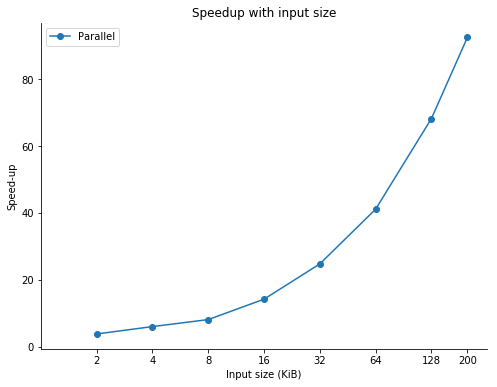

In [53]:
print("Tot_df :", tot_df.shape)

colors = [(1, "Serial"), (256, "Parallel")]

#plot_errorbars()
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(1, 1, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xscale('log', basex=2)
ax.set_xlim(1, 256)
ax.set_xticks(sorted(tot_df['num_data'].unique()))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.title("Speedup with input size")
plt.xlabel("Input size (KiB)")
plt.ylabel("Speed-up")

#
# Strong scaling with confidence intervals
#

Y1_0 = []
for num_cores, label in colors: #tot_df['num_data'].unique():
    experiment_df = tot_df.loc[tot_df['num_cores'] == num_cores]
    print("Num cores:", num_cores,"Experiment :", experiment_df.shape)
    Y1, Y1_low, Y1_high = [], [], []
    Y1_fill, Y1_argmax, Y1_reduction = [], [], []
    num_data_arr = sorted(tot_df['num_data'].unique())
    all_data = []
    all_tot = []
    
    mask = (experiment_df['num_data'] == 200)
    
    for num_data in num_data_arr:
        res_fill = []
        res_argmax = []
        res_reduction = []
        res_tot = []
        for seed in experiment_df['seed'].unique():
            mask = (experiment_df['seed'] == seed) & (experiment_df['num_data'] == num_data)
            masked = experiment_df[mask]
            if masked.empty:
                continue
            res_fill.append(      masked.loc[masked['section'] == 0]['cycles'].max() / 1000000 )
            res_argmax.append(    masked.loc[masked['section'] == 1]['cycles'].max() / 1000000 )
            res_reduction.append( masked.loc[masked['section'] == 2]['cycles'].max() / 1000000 )
            # All does not count fill section
            res_tot.append(       masked[masked['section']!=0].groupby(['core']).cycles.sum().max() / 1000000)
            all_data.append(      num_data)
            all_tot.append(       masked[masked['section']!=0].groupby(['core']).cycles.sum().max() / 1000000)
        if len(res_tot) == 0:
            continue
        lo, median, hi = median_and_ci(res_tot)
        Y1.append(median)
        Y1_low.append(lo)
        Y1_high.append(hi)
        Y1_fill.append(get_median(res_fill))
        Y1_argmax.append(get_median(res_argmax))
        Y1_reduction.append(get_median(res_reduction))
        print("(", num_data, ",", len(res_tot), ")", end=" : ")
        print("(", lo, ",", median, ",", hi, ")")
    
    Y1 = np.array(Y1)
    all_cores = np.array(all_cores)
    all_tot = np.array(all_tot)
    
 
    if num_cores != 1:
        plt.plot(num_data_arr, Y1_0/Y1, "-o", label=label)
        print(Y1_0/Y1)
    
    if num_cores == 1:
        Y1_0 = Y1

plt.legend()